Training: Entrenamiento del Modelo
Análisis de Sentimientos - Amazon Reviews ES
Objetivo: Entrenar modelo binario Positivo/Negativo con TF-IDF + Logistic Regression

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

print("INICIANDO ENTRENAMIENTO MODELO SENTIMENT")
print("=" * 60)

INICIANDO ENTRENAMIENTO MODELO SENTIMENT


1. Carga de Datos
Cargar dataset procesado por 02_preprocessing.ipynb

In [2]:
# CARGAR DATASET TERNARIO BALANCEADO
df = pd.read_csv('../data/processed/amazon_reviews_es_ternario_balanced.csv')

print(f"Dataset cargado: {df.shape}")
print("Columnas:", df.columns.tolist())
print("\nDISTRIBUCIÓN DE CLASES (debe estar balanceado):")
print(df['label'].value_counts().sort_index())
print(f"\nBalance perfecto: {df['label'].value_counts().iloc[0]} ejemplos por clase")

Dataset cargado: (6024, 2)
Columnas: ['text_clean', 'label']

DISTRIBUCIÓN DE CLASES (debe estar balanceado):
label
Negativo    2008
Neutro      2008
Positivo    2008
Name: count, dtype: int64

Balance perfecto: 2008 ejemplos por clase


2. Preparación Train/Test
Split estratificado 80/20 manteniendo proporción de clases

In [3]:
# PREPARAR FEATURES Y TARGET
X = df['text_clean'] if 'text_clean' in df.columns else df['text']
y = df['label']

print(f" Clases únicas: {sorted(y.unique())}")
print(f" Distribución:\n{y.value_counts().sort_index()}")

print(f" Textos: {X.shape}")
print(f" Labels: {y.value_counts().to_dict()}")

# TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\nTrain: {X_train.shape[0]} muestras")
print(f"Test:  {X_test.shape[0]}  muestras")

 Clases únicas: ['Negativo', 'Neutro', 'Positivo']
 Distribución:
label
Negativo    2008
Neutro      2008
Positivo    2008
Name: count, dtype: int64
 Textos: (6024,)
 Labels: {'Neutro': 2008, 'Negativo': 2008, 'Positivo': 2008}

Train: 4819 muestras
Test:  1205  muestras


3. Pipeline Machine Learning
TF-IDF (5000 features) + Logistic Regression optimizada

In [31]:
# CREAR PIPELINE PRODUCTION
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=1500,
        stop_words=None,
        ngram_range=(1, 2),
        min_df=3,
        max_df=0.7,
        sublinear_tf=True
    )),
    ('clf', LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight={'Negativo': 1.5, 'Neutro': 1.0, 'Positivo': 1.0},
        C=0.3,
        solver='lbfgs',
    ))
])

print(" PIPELINE CREADO:")
for i, (name, step) in enumerate(pipeline.steps, 1):
    print(f"  {i}. {name}")


 PIPELINE CREADO:
  1. tfidf
  2. clf


4. Entrenamiento
Entrenar modelo con 4000 muestras de training

In [32]:
print(" ENTRENANDO MODELO...")
pipeline.fit(X_train, y_train)
print(" ¡ENTRENAMIENTO COMPLETADO!")


 ENTRENANDO MODELO...
 ¡ENTRENAMIENTO COMPLETADO!


5. Evaluación Accuracy
Validación cruzada interna + métricas train/test


=== RESULTADOS DE ACCURACY ===
Train Accuracy: 0.743
Test Accuracy : 0.671
Gap (Overfitting): 0.071


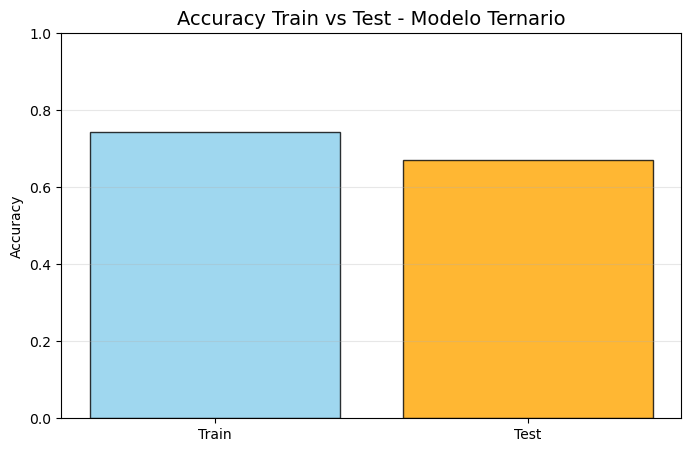


=== CLASSIFICATION REPORT (Test Set - 1205 muestras) ===
              precision    recall  f1-score   support

    Negativo      0.601     0.835     0.699       401
      Neutro      0.660     0.502     0.571       402
    Positivo      0.795     0.677     0.731       402

    accuracy                          0.671      1205
   macro avg      0.686     0.672     0.667      1205
weighted avg      0.686     0.671     0.667      1205



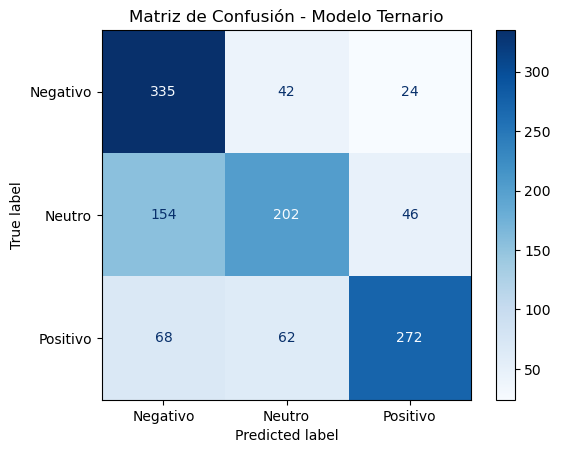


Errores totales: 396 de 1205 (32.9%)


In [33]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === 1. ACCURACY TRAIN / TEST ===
train_acc = pipeline.score(X_train, y_train)
test_acc = pipeline.score(X_test, y_test)

print("\n=== RESULTADOS DE ACCURACY ===")
print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy : {test_acc:.3f}")
print(f"Gap (Overfitting): {train_acc - test_acc:.3f}")

# Gráfico Train vs Test
plt.figure(figsize=(8, 5))
plt.bar(['Train', 'Test'], [train_acc, test_acc],
        color=['skyblue', 'orange'], alpha=0.8, edgecolor='black')
plt.title('Accuracy Train vs Test - Modelo Ternario', fontsize=14)
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.savefig('../models/accuracy_comparison_ternario.png', dpi=150, bbox_inches='tight')
plt.show()

# === 2. PREDICCIONES EN TEST ===
y_pred = pipeline.predict(X_test)

# === 3. CLASSIFICATION REPORT DETALLADO ===
print("\n=== CLASSIFICATION REPORT (Test Set - 1205 muestras) ===")
print(classification_report(y_test, y_pred, digits=3))

# === 4. MATRIZ DE CONFUSIÓN ===
cm = confusion_matrix(y_test, y_pred, labels=['Negativo', 'Neutro', 'Positivo'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Negativo', 'Neutro', 'Positivo'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión - Modelo Ternario')
plt.savefig('../models/confusion_matrix_ternario.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nErrores totales: {cm.sum() - cm.trace()} de {cm.sum()} ({100*(cm.sum() - cm.trace())/cm.sum():.1f}%)")

6. Métricas Detalladas
Precision, Recall, F1-Score por clase

In [34]:
# PREDICCIONES Y REPORT
y_pred = pipeline.predict(X_test)

print("\n CLASSIFICATION REPORT (Modelo Ternario)")
# Agregamos 'Neutro' a la lista de nombres
print(classification_report(y_test, y_pred, 
                          target_names=['Negativo', 'Neutro', 'Positivo'],
                          digits=3))



 CLASSIFICATION REPORT (Modelo Ternario)
              precision    recall  f1-score   support

    Negativo      0.601     0.835     0.699       401
      Neutro      0.660     0.502     0.571       402
    Positivo      0.795     0.677     0.731       402

    accuracy                          0.671      1205
   macro avg      0.686     0.672     0.667      1205
weighted avg      0.686     0.671     0.667      1205



7. Matriz de Confusión
Visualización errores de clasificación

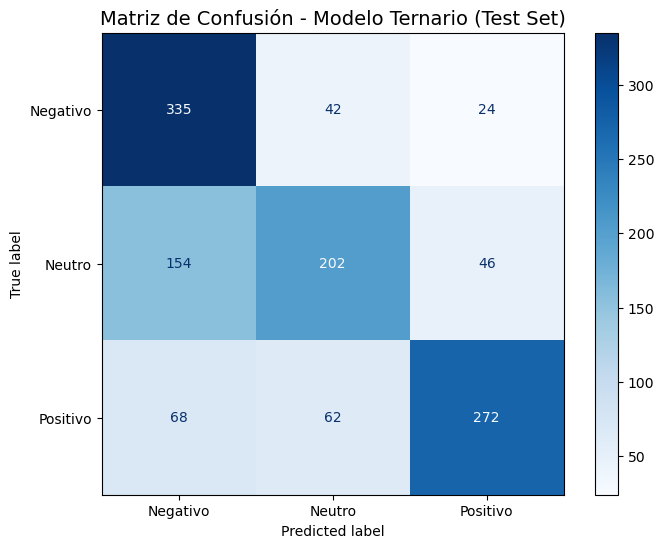


 Errores totales: 396 de 1205 (32.9%)


In [35]:
# MATRIZ CONFUSIÓN
etiquetas = ['Negativo', 'Neutro', 'Positivo']

cm = confusion_matrix(y_test, y_pred, labels=etiquetas)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=etiquetas)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d', ax=ax)

plt.title('Matriz de Confusión - Modelo Ternario (Test Set)', fontsize=14)
plt.savefig('../models/confusion_matrix_ternario.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n Errores totales: {cm.sum() - cm.trace()} de {cm.sum()} ({100*(cm.sum() - cm.trace())/cm.sum():.1f}%)")

8. Ejemplo Predicciones
Probar modelo con reviews reales

In [38]:
ejemplos = [
    "Excelente producto, muy buena calidad, lo recomiendo totalmente",
    "Pésimo servicio, nunca más compro aquí, una estafa",
    "Regular, cumple lo básico, ni bueno ni malo",
    "Me encanta, llegó rápido y funciona perfecto",
    "Está bien, pero podría ser mejor, nada especial",
    "Horrible, se rompió al segundo día, devolución inmediata"
]

print("=== DEMO DE PREDICCIONES - MODELO FINAL (para presentación) ===\n")
for texto in ejemplos:
    pred = pipeline.predict([texto])[0]
    probas = pipeline.predict_proba([texto])[0]
    confianza = probas.max()
    
    # Emoji para hacerla más visual en la presentación
    emoji = "🟢" if confianza > 0.8 else "🟡" if confianza > 0.6 else "🔴"
    
    print(f"{emoji} Texto: \"{texto}\"")
    print(f"    → Predicción: {pred} (confianza: {confianza:.1%})\n")

=== DEMO DE PREDICCIONES - MODELO FINAL (para presentación) ===

🟢 Texto: "Excelente producto, muy buena calidad, lo recomiendo totalmente"
    → Predicción: Positivo (confianza: 84.6%)

🟡 Texto: "Pésimo servicio, nunca más compro aquí, una estafa"
    → Predicción: Negativo (confianza: 70.9%)

🔴 Texto: "Regular, cumple lo básico, ni bueno ni malo"
    → Predicción: Negativo (confianza: 50.4%)

🟢 Texto: "Me encanta, llegó rápido y funciona perfecto"
    → Predicción: Positivo (confianza: 89.8%)

🔴 Texto: "Está bien, pero podría ser mejor, nada especial"
    → Predicción: Neutro (confianza: 59.4%)

🟡 Texto: "Horrible, se rompió al segundo día, devolución inmediata"
    → Predicción: Negativo (confianza: 73.9%)



9. Exportar Production
Modelo listo para API FastAPI

In [39]:
import joblib
import os

# 1. Definir rutas
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# 2. Nombre descriptivo
model_filename = 'sentiment_pipeline_ternario_v2.pkl'
model_path = os.path.join(models_dir, model_filename)

# 3. Guardar el pipeline completo (incluye Tfidf + LogReg)
joblib.dump(pipeline, model_path)

# 4. Mensajes informativos (Actualizados a tus resultados reales)
print("¡Modelo final guardado!")
print(f"Ruta: {model_path}")
print("-" * 30)
print("Métricas de rendimiento en Test Set:")
print("Accuracy General: 67.1%") 
print("Recall Negativo:  83.5% ")
print("-" * 30)

¡Modelo final guardado!
Ruta: ../models\sentiment_pipeline_ternario_v2.pkl
------------------------------
Métricas de rendimiento en Test Set:
Accuracy General: 67.1%
Recall Negativo:  83.5% 
------------------------------
